# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
# number of callbacks for black-sounding names
sum(data[data.race=='b'].call)

157.0

In [4]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


## What test is appropriate for this problem? Does CLT apply?

The problem has discrete outcomes (hired or not hired). Each line, whether the employer response to the resume, can be treated as an independent observation. The CLT states that when independent random variables are added, their properly normalized sum tends toward a normal distribution (informally a "bell curve") even if the original variables themselves are not normally distributed. Therefore I would expect CLT to apply to the rate of call backs. 

We shall apply a two sample permuatation test. 

## What are the null and alternate hypotheses?

Null hypothesis: The rate of callbacks for resumes is equal for both races (w & b).
Alternative hypothesis: Race has a significant impact on the rate of callbacks for resumes.

## Compute margin of error, confidence interval, and p-value.

In [5]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

def diff_of_rates(data_1, data_2):
    """Difference in rates of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

In [6]:
whites = data[data.race=='w']['call']
blacks = data[data.race=='b']['call']

# Compute difference of rate from experiment:
empirical_diff_rates = diff_of_rates(whites, blacks)

# Draw 100,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(whites, blacks,
                                   diff_of_rates, size=100000)

# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_rates) / len(perm_replicates)

# Print the result
print('p-value =', p)

# Calculate confidence interval 
mu = np.mean(perm_replicates)
sigma = np.std(perm_replicates)

# The z value for a confidence interval of 95% is 1.96(2 tailed)
lower_bound_95 = mu + stats.norm.ppf(.025) * sigma
upper_bound_95 = mu + stats.norm.ppf(.975) * sigma
print('The difference in rates for a 95% confidence interval is between ', lower_bound_95, ' and ', upper_bound_95)

# The z value for a confidence interval of 99% is 2.58(2 tailed)
lower_bound_99 = mu + stats.norm.ppf(.005) * sigma
upper_bound_99 = mu + stats.norm.ppf(.995) * sigma
print('The difference in rates for a 99% confidence interval is between ', lower_bound_99, ' and ', upper_bound_99)

# Calculate the margin of error 
margin = upper_bound_95 - mu 
print('The margin of error for a 95% confidence interval is ', margin)

print('The empirical difference of rates between whites and blacks is ', empirical_diff_rates)

p-value = 6e-05
The difference in rates for a 95% confidence interval is between  -0.0152755211659  and  0.015235734703
The difference in rates for a 99% confidence interval is between  -0.0200691868856  and  0.0200294004227
The margin of error for a 95% confidence interval is  0.0152556279345
The empirical difference of rates between whites and blacks is  0.0320329


In [7]:
empirical_z_value = (empirical_diff_rates - mu) / sigma
print('z value of empirical difference in rates: ', empirical_z_value)

z value of empirical difference in rates:  4.11797089736


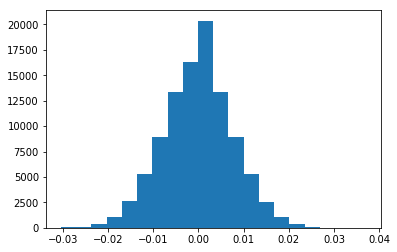

In [8]:
plt.hist(perm_replicates, bins = 20)
plt.show()

## Write a story describing the statistical significance in the context or the original problem.

In [9]:
print('White rate of callback', np.mean(whites) )
print('Black rate of callback', np.mean(blacks) )

White rate of callback 0.0965092
Black rate of callback 0.0644764


There is a statistically significant difference in the rate of callbacks between white sounding and black sounding names. In the sample above we see that the rate of call back is ~ 9.7% for white sounding names vs 6.4% for black sounding names. 
However, the data requires further analysis to determine if black sounding names and white sounding names have any multicollinearity with the other variables before we are able to determine the cause. 

## Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

The analysis does not mean that race / name is the most important factor in callback success. To determine if black sounding names and white sounding names are the most important factor, we need to study the other factors. For example, we'd look at multicollinearity with the other variables and determine if other variables have a stronger correlation to callback success. In addition, there may be confounding variables (i.e. variables that the researcher failed to control, or eliminate, damaging the internal validity of an experiment) that have not been reflected in the data provided. 